In [31]:
import numpy as np
import pandas as pd
import seaborn as sns
import altair as alt
import joblib

from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8')

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, mean_squared_error, mean_absolute_error

import gc

import logging
import warnings

warnings.filterwarnings('ignore')

In [7]:
!pip install tabulate

In [8]:
!pip install optuna

In [9]:
import optuna

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/Fall_2025/CPSC_5305_Intro_to_DS/data/"
MODEL_PATH = "/content/drive/MyDrive/Colab Notebooks/Fall_2025/CPSC_5305_Intro_to_DS/models/"

In [12]:
def reduce_mem_usage(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtype

        # --- FIX: Skip Datetime Columns ---
        if pd.api.types.is_datetime64_any_dtype(col_type):
            continue
        # -----------------------------------

        # Only process numeric columns for min/max
        if col_type != object and not isinstance(col_type, pd.CategoricalDtype):
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                else:
                    df[col] = df[col].astype(np.int64)
            else:
                # This is where the error occurred previously for datetime types
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        # Handle categorical columns without min/max
        elif isinstance(col_type, pd.CategoricalDtype):
            df[col] = df[col].cat.as_unordered()  # Ensure no ordering assumption
        else:
            df[col] = df[col].astype('category')  # Convert objects to category
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print(f'Memory usage decreased from {start_mem:.2f} Mb to {end_mem:.2f} Mb ({100 * (start_mem - end_mem) / start_mem:.1f}% reduction)')
    return df

In [13]:
print("Loading and reducing memory usage for data files...")
df = pd.read_parquet(f'{DATA_PATH}final_m5_model_data.parquet')
df = reduce_mem_usage(df)
print("\nInitial data loading complete.")

Loading and reducing memory usage for data files...
Memory usage decreased from 10068.35 Mb to 6007.70 Mb (40.3% reduction)

Initial data loading complete.


In [14]:
print(df.head().to_markdown())

|    | item_id     | dept_id   | cat_id   | store_id   | state_id   | d    |   sales |   sell_price | date                |   wday |   month |   year |   snap_CA |   snap_TX |   snap_WI | event_name_1   | event_type_1   | event_name_2   | event_type_2   |   has_sale |   quarter |   week |   day_of_week |   day_of_month |   day_of_year |   weekend |   price_mean |   price_relative_to_mean |   price_change_lag |   sales_lag_1 |   sales_lag_7 |   sales_lag_28 |   sales_rolling_mean_7 |   sales_rolling_mean_28 |   price_lag_7 |   price_lag_28 |   month_sin |   month_cos |   day_of_month_sin |   day_of_month_cos |   day_of_week_sin |   day_of_week_cos |
|---:|:------------|:----------|:---------|:-----------|:-----------|:-----|--------:|-------------:|:--------------------|-------:|--------:|-------:|----------:|----------:|----------:|:---------------|:---------------|:---------------|:---------------|-----------:|----------:|-------:|--------------:|---------------:|--------------:|-----

In [15]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58327370 entries, 0 to 58327369
Data columns (total 42 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   item_id                 category      
 1   dept_id                 category      
 2   cat_id                  category      
 3   store_id                category      
 4   state_id                category      
 5   d                       category      
 6   sales                   int16         
 7   sell_price              float32       
 8   date                    datetime64[ns]
 9   wday                    int8          
 10  month                   int8          
 11  year                    int16         
 12  snap_CA                 int8          
 13  snap_TX                 int8          
 14  snap_WI                 int8          
 15  event_name_1            category      
 16  event_type_1            category      
 17  event_name_2            category      
 18  

In [16]:
print(df.shape)

(58327370, 42)


In [17]:
gc.collect()

60

In [18]:
print(df.isnull().sum().to_markdown())

|                        |   0 |
|:-----------------------|----:|
| item_id                |   0 |
| dept_id                |   0 |
| cat_id                 |   0 |
| store_id               |   0 |
| state_id               |   0 |
| d                      |   0 |
| sales                  |   0 |
| sell_price             |   0 |
| date                   |   0 |
| wday                   |   0 |
| month                  |   0 |
| year                   |   0 |
| snap_CA                |   0 |
| snap_TX                |   0 |
| snap_WI                |   0 |
| event_name_1           |   0 |
| event_type_1           |   0 |
| event_name_2           |   0 |
| event_type_2           |   0 |
| has_sale               |   0 |
| quarter                |   0 |
| week                   |   0 |
| day_of_week            |   0 |
| day_of_month           |   0 |
| day_of_year            |   0 |
| weekend                |   0 |
| price_mean             |   0 |
| price_relative_to_mean |   0 |
| price_ch

## Modeling

1. The "Categorical Feature" Problem:

This is the most important reason. Linear models like LinearRegression and Ridge can't handle categorical features like item_id, store_id, or dept_id directly.

The technically correct way to use them is one-hot encoding but it is impossible. Because our item_id column has over 3,000 unique items. One-hot encoding it would add 3,000+ new columns to the DataFrame. Doing this for all categorical features would add thousands of columns, exploding your DataFrame from 33 features to ~3,200+ features.

So, definitely, the notebook will instantly crash from a memory explosion. (out of memory usage)

That's why tree models are the solution. They are specifically designed to handle high-cardinality categorical features without one-hot encoding, saving us from this memory crisis.

2. Linear models can only find simple, a straight-line relationships.

The Heatmap from the EDA and Feature Engineering step proved this:
- We saw that snap_CA and weekend have a 0.00 correlation with sales. A linear model will look at this 0.00 and conclude that "this feature is useless". But in reality, we know a weekend day boosts sales, and a snap day boosts food sales. So, this is a complex, non-linear rule.

Tree models are the solution here, too. They excel at finding these complex, non-linear patterns and "if-then" rules. A tree model can easily learn:

- "IF day_of_week is a weekend AND category is 'FOODS', THEN sales go up"

A linear model can never discover this rule.

Summary: We have to move to tree models because linear models can't handle your most important features (the categories) and can't understand the most important patterns (the non-linear rules).

In [19]:
gc.collect()

0

## Random Forest

In [20]:
# list of all categorical features
cat_features = [
    'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id',
    'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2'
]

# create a copy to avoid SettingWithCopyWarning
df_encoded = df.copy()

print("Encoding categorical features...")
for col in cat_features:
    # init a new LabelEncoder for each column
    encoder = LabelEncoder()
    # fit and transform the column
    df_encoded[col] = encoder.fit_transform(df_encoded[col].astype(str))

print("Encoding complete.")

Encoding categorical features...
Encoding complete.


In [21]:
gc.collect()

0

In [22]:
target = 'sales'

redundant_features = [
    'has_sale', 'date', 'd'
]

columns_to_drop = [target] + redundant_features

features = [col for col in df_encoded.columns if col not in columns_to_drop]

print(f"Target variable: {target}")
print(f"Total features being used: {len(features)}")

Target variable: sales
Total features being used: 38


In [23]:
N_ITEMS = 30490 # 30490 items
print(N_ITEMS)

30490


In [24]:
print("Sorting dataframe...")
df_encoded = df_encoded.sort_values(['item_id', 'store_id', 'date']).reset_index(drop=True)

VALID_DAYS = 28
split_date = df_encoded['date'].unique()[-VALID_DAYS]
print(f"Splitting data at date: {split_date}")

train_df = df_encoded[df_encoded['date'] < split_date].copy()
valid_df = df_encoded[df_encoded['date'] >= split_date].copy()

X_train = train_df[features]
y_train = train_df[target]

X_valid = valid_df[features]
y_valid = valid_df[target]

print(f"Training set shape:   {X_train.shape}")
print(f"Validation set shape: {X_valid.shape}")

del df_encoded
gc.collect()

Sorting dataframe...
Splitting data at date: 2016-04-25 00:00:00
Training set shape:   (57473650, 38)
Validation set shape: (853720, 38)


0

In [25]:
gc.collect()

0

In [26]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 10, 30),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 20, 150),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 50),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'n_jobs': -1,
        'random_state': 42
    }

    fraction = 0.1
    if fraction < 1.0:
        sample_indices = np.random.choice(X_train.index, size=int(len(X_train) * fraction), replace=False)
        X_train_opt = X_train.loc[sample_indices]
        y_train_opt = y_train.loc[sample_indices]
    else:
        X_train_opt = X_train
        y_train_opt = y_train

    model = RandomForestRegressor(**params)
    model.fit(X_train_opt, y_train_opt)

    preds = model.predict(X_valid)
    rmse = np.sqrt(mean_squared_error(y_valid, preds))

    return rmse

In [27]:
print("Starting Optuna optimization...")
study = optuna.create_study(direction='minimize', study_name="RandomForest_Tunning")
study.optimize(objective, n_trials=20)

print("\nBest RMSE:", study.best_value)
print("Best Parameters:", study.best_params)

[I 2025-12-06 04:31:38,101] A new study created in memory with name: RandomForest_Tunning


Starting Optuna optimization...


[I 2025-12-06 04:32:57,963] Trial 0 finished with value: 1.9679875245331997 and parameters: {'n_estimators': 145, 'max_depth': 12, 'min_samples_leaf': 29, 'min_samples_split': 4, 'max_features': 'sqrt'}. Best is trial 0 with value: 1.9679875245331997.
[I 2025-12-06 04:35:01,937] Trial 1 finished with value: 1.9630857469253133 and parameters: {'n_estimators': 196, 'max_depth': 30, 'min_samples_leaf': 44, 'min_samples_split': 37, 'max_features': 'log2'}. Best is trial 1 with value: 1.9630857469253133.
[I 2025-12-06 04:38:00,544] Trial 2 finished with value: 1.9685244764779575 and parameters: {'n_estimators': 276, 'max_depth': 20, 'min_samples_leaf': 118, 'min_samples_split': 29, 'max_features': 'sqrt'}. Best is trial 1 with value: 1.9630857469253133.
[I 2025-12-06 04:38:59,503] Trial 3 finished with value: 1.9653774275905491 and parameters: {'n_estimators': 74, 'max_depth': 30, 'min_samples_leaf': 66, 'min_samples_split': 42, 'max_features': 'sqrt'}. Best is trial 1 with value: 1.9630857


Best RMSE: 1.958420144923013
Best Parameters: {'n_estimators': 234, 'max_depth': 25, 'min_samples_leaf': 22, 'min_samples_split': 34, 'max_features': 'log2'}


In [28]:
print("Training Final Random Forest Model on Full Data...")

best_params = study.best_params
best_params['n_jobs'] = -1
best_params['random_state'] = 42
best_params['verbose'] = 1

final_model = RandomForestRegressor(**best_params)
final_model.fit(X_train, y_train)

print("Final Training Complete.")

Training Final Random Forest Model on Full Data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 44 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 12.6min


Final Training Complete.


[Parallel(n_jobs=-1)]: Done 234 out of 234 | elapsed: 23.0min finished


In [29]:
print("Evaluating...")
val_preds = final_model.predict(X_valid)

rmse = np.sqrt(mean_squared_error(y_valid, val_preds))
mse = mean_squared_error(y_valid, val_preds)
mae = mean_absolute_error(y_valid, val_preds)

print(f"Final Validation RMSE: {rmse:.4f}")
print(f"Final Validation MSE:  {mse:.4f}")
print(f"Final Validation MAE:  {mae:.4f}")

[Parallel(n_jobs=44)]: Using backend ThreadingBackend with 44 concurrent workers.


Evaluating...


[Parallel(n_jobs=44)]: Done 112 tasks      | elapsed:    1.0s


Final Validation RMSE: 1.9392
Final Validation MSE:  3.7606
Final Validation MAE:  0.9933


[Parallel(n_jobs=44)]: Done 234 out of 234 | elapsed:    1.8s finished


In [32]:
print("Saving model...")
save_path = f'{MODEL_PATH}final_m5_model_random_forest_tunned.joblib'
joblib.dump(final_model, save_path)
print(f"\n Model saved successfully to: {save_path}")

Saving model...

 Model saved successfully to: /content/drive/MyDrive/Colab Notebooks/Fall_2025/CPSC_5305_Intro_to_DS/models/final_m5_model_random_forest_tunned.joblib


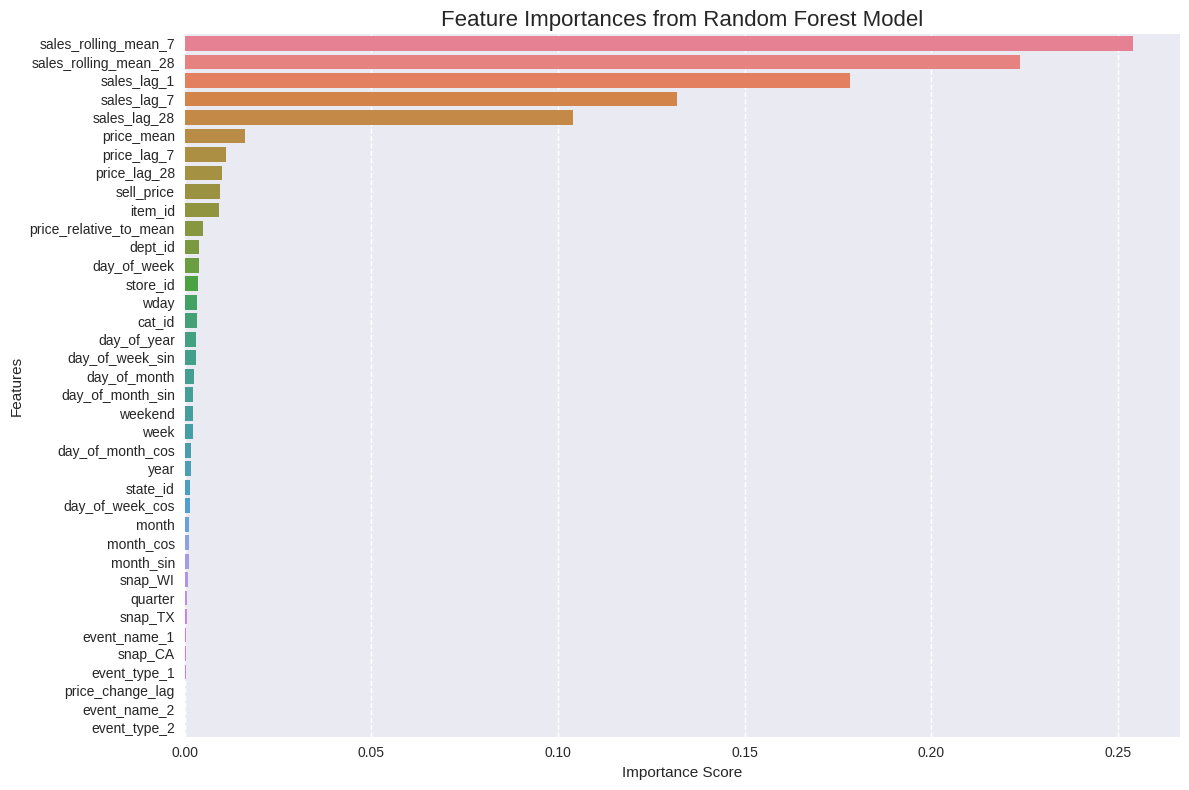

In [33]:
feature_importances = pd.Series(
    final_model.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(
    x=feature_importances,
    y=feature_importances.index,
    hue=feature_importances.index,
)

plt.title('Feature Importances from Random Forest Model', fontsize=16)
plt.xlabel('Importance Score')
plt.ylabel('Features')

plt.grid(axis='x', linestyle='--')

plt.tight_layout()
plt.show()

The Feature Importance chart shows that sales_rolling_mean_7 accounts for well over 90% of the model's predictive power. The correlation matrix (from feature engineering) confirms this, showing a very high 0.82 correlation between sales and sales_rolling_mean_7.

This is a problem because the model has essentially learned one rule: "The best guess for sales today is the average of sales from the last 7 days." While this is intuitive and gives us a decent baseline RMSE, it's a "lazy" model. It's not learning the complex, underlying patterns.

Because that one feature is so dominant, the model is ignoring other crucial information. The impact of price, SNAP events, day of the week, and item type (which are all known to drive sales) is being drowned out. To improve, the model must learn from these other features

## So, if we want to improve the model, we should remove sales_rolling_mean_7 and adding more lag features to force the model to learn from multiple signals like sales_lag_7, sales_lag_14, sales_lag_28, sales_rolling_mean_28

But I will try to use Boosting Model like XGBoost or LightGBM

In [34]:
gc.collect()

1147